# Projections

```{seealso}
The Vast DB SDK API Documentation is available [here](https://vastdb-sdk.readthedocs.io).
```

## What is a projection?

A projection is 
a subset of a database table’s columns 
that are copied into a separate table and 
sorted into chunks for accelerated queries  

When the source table is queried for columns that have been projected, the query will access the projection for better performance.

A background process updates the projection, and if no projected value is available, the source table will be used.

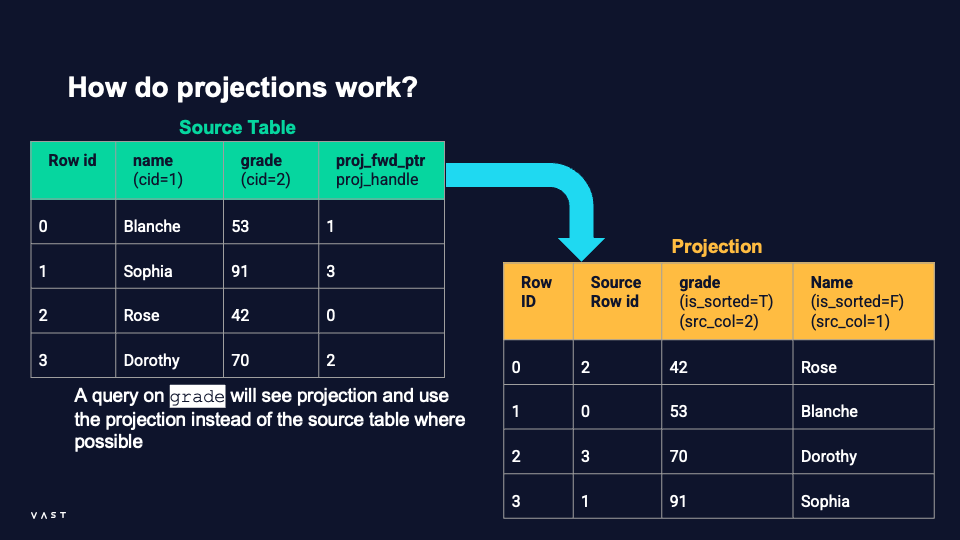


## How do projections work

1. Create a projection with a subset of columns, choosing which column(s) to sort by
2. A background process creates the projection table and adds pointers to the source table and the projection table 
- The projection is sharded and sorted in 8*216 = 524,288 row chunks
- The query engine see the pointers and can easily jump back and forth between the two
3. Updates and deletes don’t trigger a re-sort process (not needed)
4. Queries with the projected columns will use the projection table when possible, and if the projection doesn’t include a row, will use the source table instead.
5. End users shouldn’t need to understand the projection, they’ll just see that the query is accelerated.

## Install and Import the Vast DB SDK

Before doing anything else, we need to import the vastdb api library.

In [1]:
!pip install vastdb | tail -5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 6.8 MB/s eta 0:00:00


Note that below we import annotations.  This mode makes Python's behavior more strict, including raising errors for some cases where variables are accidentally undefined.

In [2]:
import vastdb
from __future__ import annotations  # Enable stricter type checking

## Creating the session

In the code below, we read the connection details from environment variables to enable automated teesting of the notebook.

Change these to reflect your environment, e.g.

```python
ENDPOINT = 'http://your_vast_endpoint:12345'
DATABASE_NAME = ...
```

In [3]:
import os

ENDPOINT = os.environ['ENDPOINT']
ACCESS_KEY = os.environ['ACCESS_KEY']
SECRET_KEY = os.environ['SECRET_KEY']

DATABASE_NAME = os.environ['DATABASE_NAME']

# Schema will get created if it doesn't exist 
DATABASE_SCHEMA = os.environ['DATABASE_SCHEMA']

# The table name this notebook will create for projections
TABLE_NAME = os.environ['TABLE_NAME']

In [ ]:
print(f"""
{ENDPOINT=} 
{ACCESS_KEY=}
{DATABASE_NAME=}
{DATABASE_SCHEMA=}
{TABLE_NAME=}
""")

In [5]:
import pyarrow as pa
import vastdb
import os

session = vastdb.connect(
    endpoint=ENDPOINT,
    access=ACCESS_KEY,
    secret=SECRET_KEY)

In [6]:
print("Vast Cluster version: ", session.api.vast_version)

Vast Cluster version:  (5, 1, 0, 131)


## Create a table for the projection

In [ ]:
import pyarrow as pa
from vastdb.errors import TableExists

ARROW_SCHEMA = pa.schema([
        ('Citizen_Age', pa.int64()),
        ('Citizen_Name', pa.string()),
        ('Citizen_experience', pa.float64()),
        ('Is_married', pa.bool_()),
    ])


with session.transaction() as tx:
    try:
        schema = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA, fail_if_missing=False)
        if not schema:
            schema = tx.bucket(DATABASE_NAME).create_schema(name=DATABASE_SCHEMA)
        try:
            table = schema.create_table(table_name=TABLE_NAME, columns=ARROW_SCHEMA)
            print(f"Table created: {table.name}")
        except TableExists as e:
            raise RuntimeError("Couldn't create table because it already exists", e)
        except Exception as e:
            print("Couldn't create table:", e)
    except Exception as e:
        print("Schema doesn't exist:", e)

Table created: pythonsdkcitizen


## Insert rows into the Citizen Table

In [ ]:
ROWS = { 
    'Citizen_Name': ['Alice', 'Bob', 'Koko', 'Menny'],
    'Citizen_Age': [45, 38, 27, 51],
    'Citizen_experience': [25.5, 17.9, 5.3, 28.2],
    'Is_married': [True, False, False, True]
}
PA_RECORD_BATCH = pa.RecordBatch.from_pydict(ROWS)


with session.transaction() as tx:
    try:
        schema = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA, fail_if_missing=True)
        try:
            table = schema.table(name=TABLE_NAME)
            table.insert(PA_RECORD_BATCH)
            print("Data inserted.")
        except Exception as e:
            print("Couldn't insert data:", e)
    except Exception as e:
        print("Schema doesn't exist:", e)

Data inserted.


This uses the [RecordBatch.from_pydict](https://arrow.apache.org/docs/python/generated/pyarrow.RecordBatch.html#pyarrow.RecordBatch.from_pydict) method.  See also:

- [RecordBatch.from_arrays](https://arrow.apache.org/docs/python/generated/pyarrow.RecordBatch.html#pyarrow.RecordBatch.from_arrays)
- [RecordBatch.from_pandas](https://arrow.apache.org/docs/python/generated/pyarrow.RecordBatch.html#pyarrow.RecordBatch.from_pandas)
- [RecordBatch.from_pylist](https://arrow.apache.org/docs/python/generated/pyarrow.RecordBatch.html#pyarrow.RecordBatch.from_pylist)
- [RecordBatch.from_struct_array](https://arrow.apache.org/docs/python/generated/pyarrow.RecordBatch.html#pyarrow.RecordBatch.from_struct_array)

### Query the table, listing all rows


In [ ]:
def list_rows():
    print(f"Listing rows in: Database='{DATABASE_NAME}' Schema='{DATABASE_SCHEMA}' Table='{TABLE_NAME}'")
    with session.transaction() as tx:
        try:
            schema = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA, fail_if_missing=True)
            try:
                table = schema.table(name=TABLE_NAME)
                reader = table.select()
                pyarrow_table = pa.Table.from_batches(reader)
                df = pyarrow_table.to_pandas()
                display(df)
            except Exception as e:
                print("Couldn't select data:", e)
        except Exception as e:
            print("Schema doesn't exist:", e)

list_rows()

,Citizen_Age,Citizen_Name,Citizen_experience,Is_married
0,45,Alice,25.5,True
1,38,Bob,17.9,False
2,27,Koko,5.3,False
3,51,Menny,28.2,True


## `create_projection`

- **Usage**: Creates a new semi-sorted projection on the table.
- **Parameters**:
  - `projection_name` (str): The name of the new projection.
  - `sorted_columns` (List[str]): A list of column names that should be sorted in the projection.
  - `unsorted_columns` (List[str]): A list of column names that should not be sorted in the projection.
- **Raises**:
  - `errors.NotSupportedCommand`: If the operation is not supported on the current table.
- **Returns**:
  - `Projection`: The newly created projection.
- **Note**:
  - A projection is a subset of a table's data, where some columns are sorted and others are not. This can be useful for optimizing certain types of queries.

In [56]:
PROJECTION_SORTED_COLUMNS = [ 'Citizen_Age' ]
PROJECTION_UNSORTED_COLUMNS = [ 'Citizen_Name', 'Is_married' ]
PROJECTION_NAME = 'demo-projection'

with session.transaction() as tx:
    try:
        table = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA).table(name=TABLE_NAME)
        try:
            projections = table.projections(PROJECTION_NAME)
            if projections:
                raise RuntimeError(f"Projection {PROJECTION_NAME} already exists.")
            
            projection = table.create_projection(
                                    PROJECTION_NAME, 
                                    sorted_columns=PROJECTION_SORTED_COLUMNS, 
                                    unsorted_columns=PROJECTION_UNSORTED_COLUMNS
                                    )
            print("Projection created:", projection)
        except Exception as e:
            print("Exception encountered:", e)
    except Exception as e:
        print("Schema doesn't exist:", e)

Projection created: Projection(name='demo-projection', table=Table(name='pythonsdkcitizen', schema=Schema(name='python-sdk-schema', bucket=Bucket(name='demo-database', tx=Transaction(id=0x000030000000002d))), handle=1877086195346196137, stats=TableStats(num_rows=6, size_in_bytes=169, is_external_rowid_alloc=False, endpoints=()), _imports_table=False), handle=8168954746074489682, stats=TableStats(num_rows=0, size_in_bytes=0, is_external_rowid_alloc=False, endpoints=()))


## `projections`

- **Usage**: Lists all semi-sorted projections of this table or a specific projection if a name is provided.
- **Parameters**:
  - `projection_name` (str, optional): The name of the projection to list. If not provided, all projections are listed.
- **Raises**:
  - `errors.NotSupportedCommand`: If the operation is not supported on the current table.
- **Returns**:
  - `List[Projection]`: A list of Projection objects representing the projections of this table.
- **Note**:
  - A projection is a subset of a table's data, where some columns are sorted and others are not. This can be useful for optimizing certain types of queries.


In [57]:
print(f"Executing: table.projections('{PROJECTION_NAME}')")

with session.transaction() as tx:
    try:
        table = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA).table(name=TABLE_NAME)
        try:
            projections = table.projections(PROJECTION_NAME)
            for p in projections:
                print(p)
        except Exception as e:
            print("Exception encountered:", e)
    except Exception as e:
        print("Schema doesn't exist:", e)

Projection created: [Projection(name='demo-projection', table=Table(name='pythonsdkcitizen', schema=Schema(name='python-sdk-schema', bucket=Bucket(name='demo-database', tx=Transaction(id=0x000030000000002e))), handle=1877086195346196137, stats=TableStats(num_rows=6, size_in_bytes=169, is_external_rowid_alloc=False, endpoints=()), _imports_table=False), handle=8168954746074489682, stats=TableStats(num_rows=0, size_in_bytes=0, is_external_rowid_alloc=False, endpoints=()))]


### Projection Stats

The projects are synced in the backend and it can take some time until you will see the stats. 

The stats can be found in the reponse from `table.projections()`.  E.g.

```
Projection(
    name='demo-projection',
    table=Table(name='pythonsdkcitizen',
    ...
    stats=TableStats(num_rows=6, size_in_bytes=169, is_external_rowid_alloc=False, endpoints=()),
    ...
)
```

## `rename`

- **Usage**: Renames this projection.
- **Parameters**:
  - `new_name` (str): The new name for the projection.
- **Raises**:
  - `errors.NotSupportedCommand`: If the operation is not supported on the current table.
- **Note**:
  - This operation will change the name of the projection in the database. The change is reflected in the 'name' attribute of this object.

In [58]:
PROJECTION_NAME = 'demo-projection'
PROJECTION_NAME_RENAMED = 'demo-projection-renamed'

with session.transaction() as tx:
    try:
        table = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA).table(name=TABLE_NAME)
        try:
            projection = table.projection(PROJECTION_NAME)
            print("Projection name before rename:", projection.name)

            projection.rename(PROJECTION_NAME_RENAMED)
            projection = table.projection(PROJECTION_NAME_RENAMED)
            print("Projection name after rename:", projection.name)
            
        except Exception as e:
            print("Exception encountered:", e)
    except Exception as e:
        print("Schema doesn't exist:", e)

Projection name before rename: demo-projection
Projection name after rename: demo-projection-renamed


## `drop`

- **Usage**: Drops (deletes) this table from the VAST Database.  This operation is irreversible and will permanently remove the table along with all its data and associated metadata from the database.
- **Parameters**:
  - None
- **Raises**:
  - `VastDBError`: If there is an error communicating with the VAST server or if the table cannot be dropped due to permissions issues or other server-side constraints.
- **Note**: This method will also remove any imports table associated with this table.

In [59]:
def list_projections():
    with session.transaction() as tx:
        try:
            table = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA).table(name=TABLE_NAME)  
            try:                 
                projections = table.projections()
                print(f"Found {len(projections)} projections.")
                for p in projections:
                    print(f'>>> {p.name}')
            except Exception as e:
                import sys, traceback
                traceback.print_exc(file=sys.stdout)
                print("Exception encountered:", e)
        except Exception as e:
            print("Schema doesn't exist:", e)

list_projections()

Found 1 projections.
>>> demo-projection-renamed


In [60]:
PROJECTION_NAME_RENAMED = 'demo-projection-renamed'

with session.transaction() as tx:
    try:
        table = tx.bucket(DATABASE_NAME).schema(name=DATABASE_SCHEMA).table(name=TABLE_NAME) 
        try:             
            projection = table.projection(PROJECTION_NAME_RENAMED)
            projection.drop()
        except vastdb.errors.MissingProjection:
            print("Projection not found.")
        except Exception as e:
            import sys, traceback
            traceback.print_exc(file=sys.stdout)
            print("Exception encountered:", e)
    except Exception as e:
        print("Schema doesn't exist:", e)

In [61]:
list_projections()

Found 0 projections.
